In [1]:
import numpy as np
import pandas as pd
from matplotlib import font_manager as fm, pyplot as plt, rcParams
import seaborn as sns
plt.style.use('seaborn-colorblind')
helv=fm.FontProperties(fname='helvetica.ttf')
from scipy.stats import *

In [2]:
gwas = pd.read_table("/oak/stanford/groups/jpriest/cnv_ukb/subanalyses/cad/new_plink_files/CAD.JPL.app13721.gwas.Acute_CAD.glm.logistic.hybrid", 
                      header=0).dropna()
gwas.rename_axis({"#CHROM":"CHR", "ID":"SNP"}, axis=1, inplace=True)
gwas.tail()

,CHR,POS,SNP,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,SE,Z_STAT,P
7045,22,49874383,22:49840871-49907896_-,N,+,+,N,ADD,333666,1.002030,0.202669,0.010003,0.992019
7046,22,49874837,22:49840871-49908804_-,N,+,+,Y,ADD,333666,0.208727,1.464680,-1.069670,0.284767
7047,22,49875264,22:49840871-49909658_-,N,+,+,N,ADD,333666,0.756866,1.035690,-0.268970,0.787953
7048,22,49875565,22:49843235-49907896_-,N,+,+,Y,ADD,333666,0.300065,1.533620,-0.784911,0.432506
7049,22,49933861,22:49889954-49977768_-,N,+,+,Y,ADD,333666,0.434466,1.554570,-0.536248,0.591787


In [3]:
burden = pd.read_table("/oak/stanford/groups/jpriest/cnv_ukb/subanalyses/cad/new_plink_files/CAD.JPL.app13721.burden.mac10.Acute_CAD.glm.logistic.hybrid", 
                           header=0).dropna()
burden.rename_axis({"#CHROM":"CHR", "ID":"GENE"}, axis=1, inplace=True)
burden.tail()

,CHR,POS,GENE,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,SE,Z_STAT,P
11143,22,51063891,ARSA,N,+,+,N,ADD,333902,0.765471,1.041500,-0.256615,0.797476
11144,22,51142354,SHANK3,N,+,+,N,ADD,333902,0.669669,0.367842,-1.090070,0.275684
11145,22,51180189,ACR,N,+,+,N,ADD,333902,0.796688,0.737435,-0.308220,0.757915
11146,22,51214003,RABL2B,N,+,+,N,ADD,333902,1.270500,1.088860,0.219869,0.825973
11147,22,51216789,RPL23AP82,N,+,+,N,ADD,333902,1.270500,1.088860,0.219869,0.825973


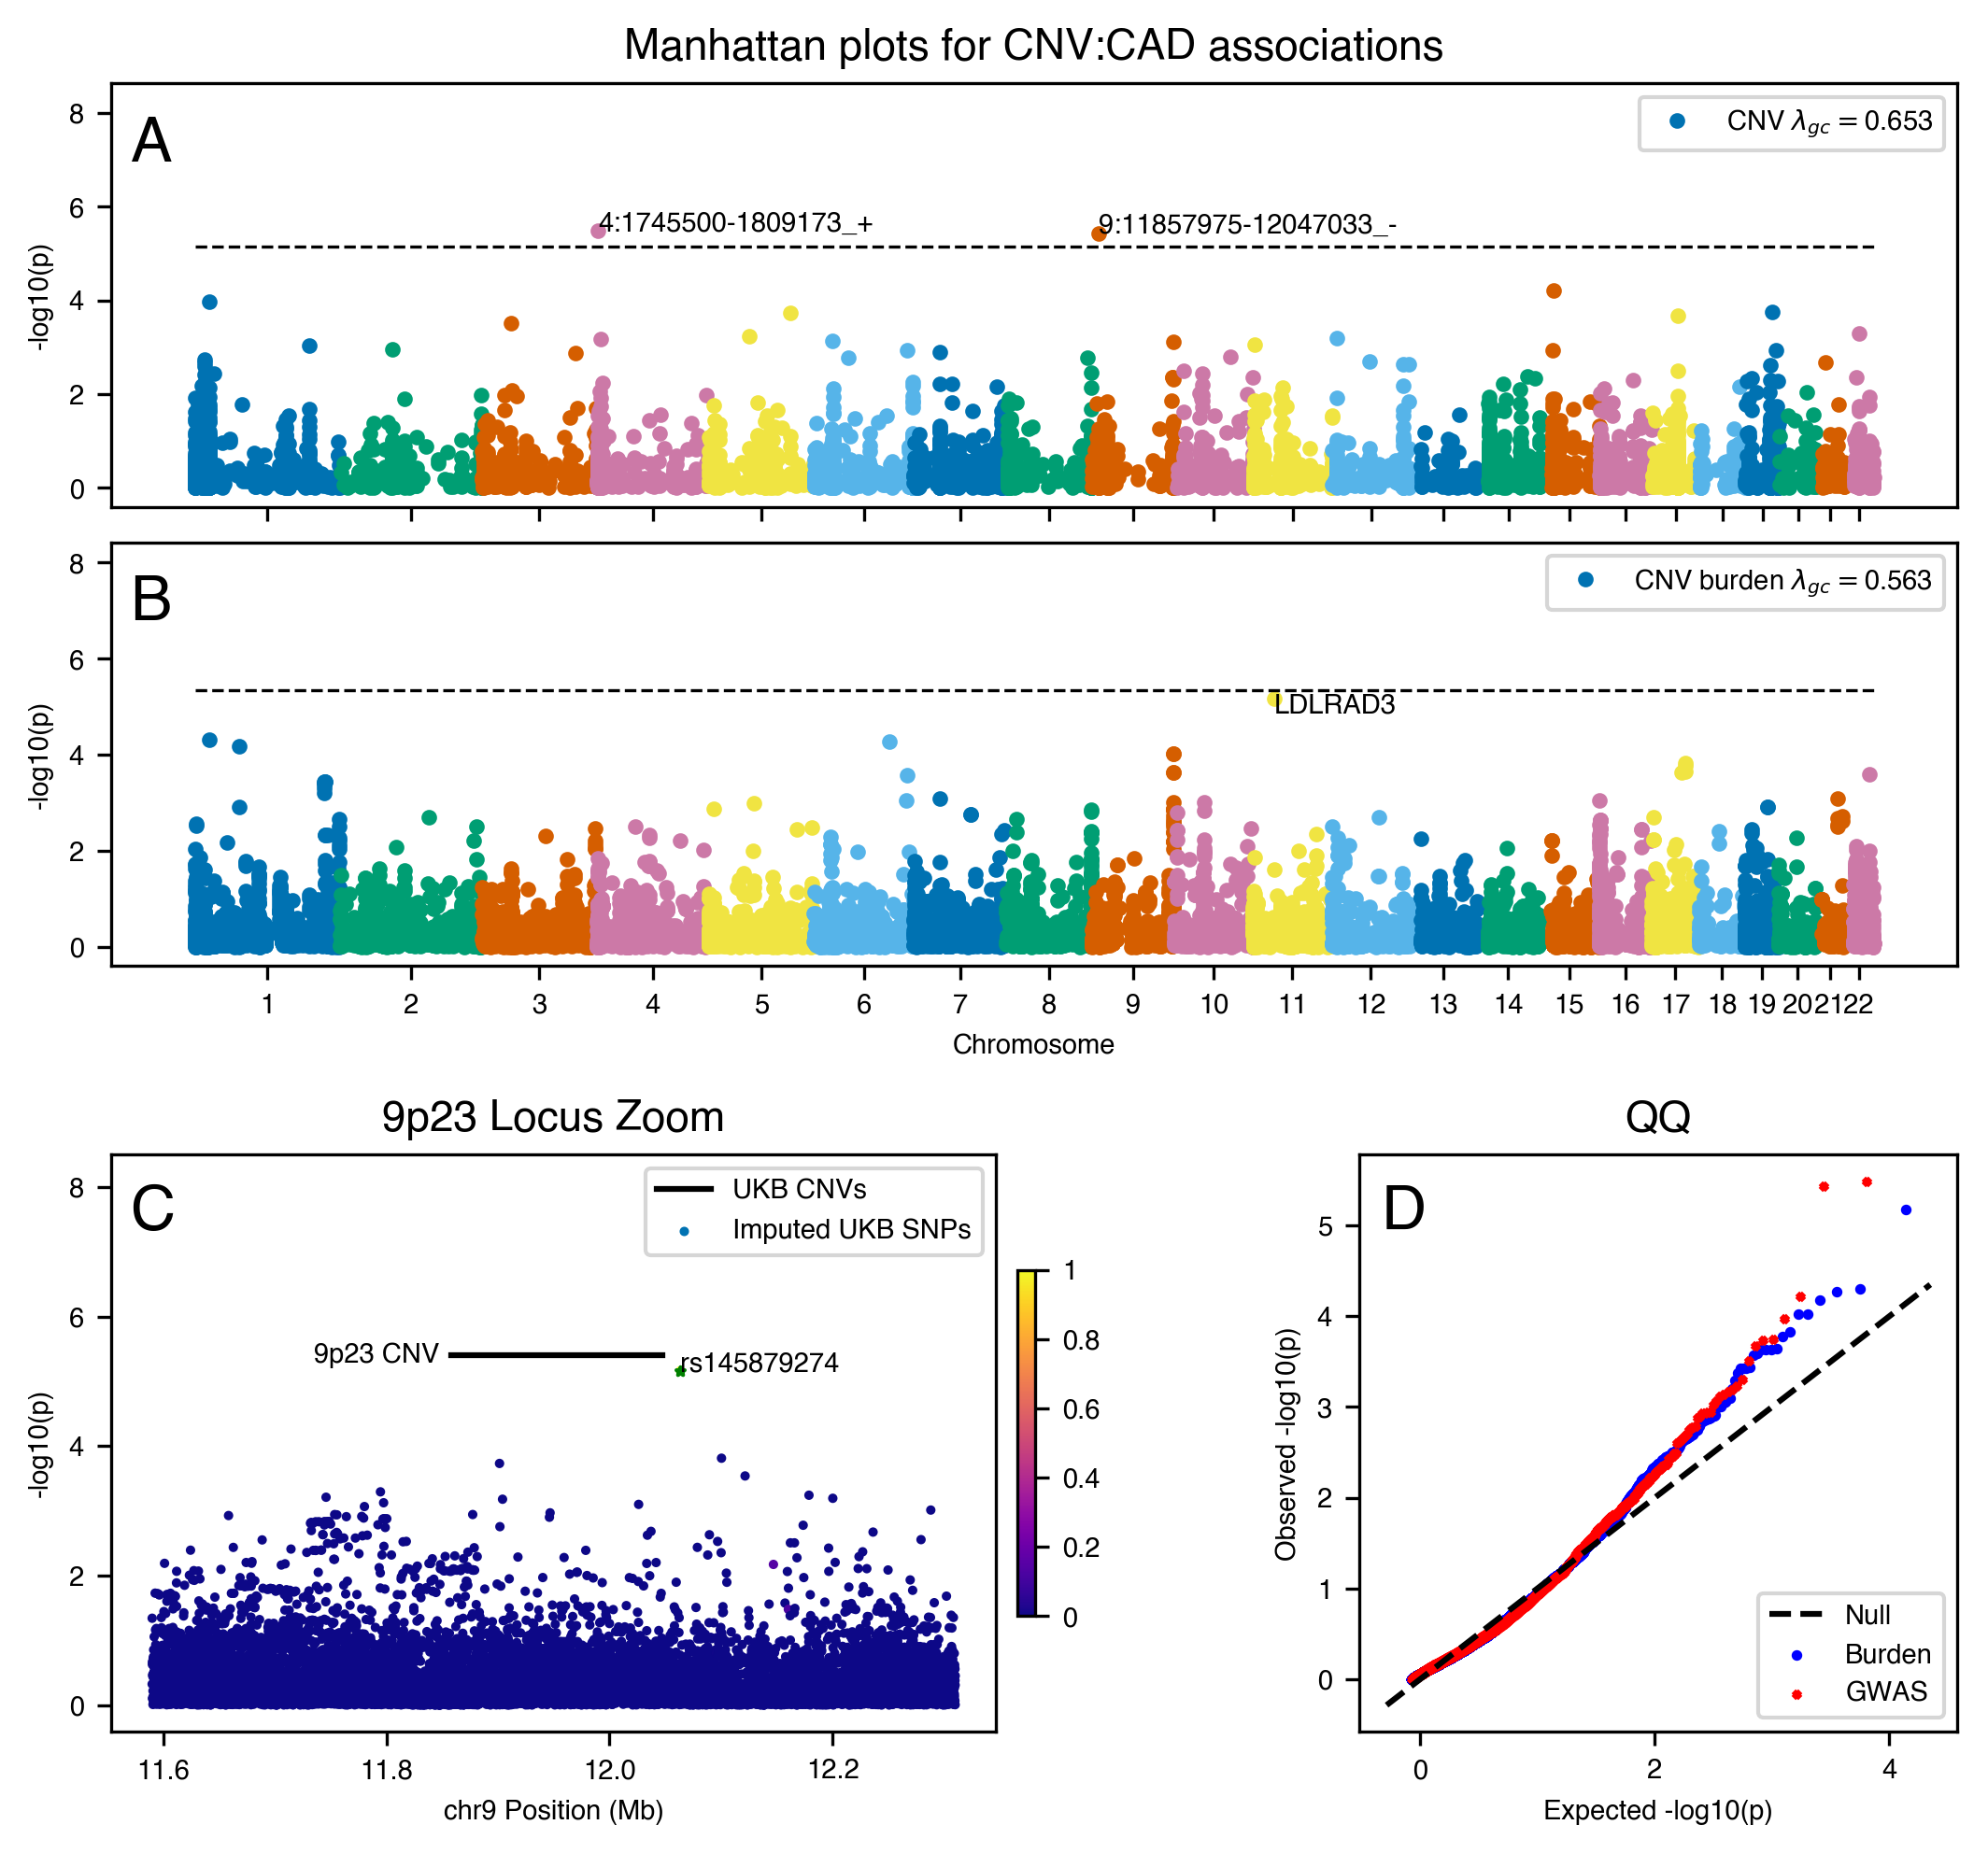

In [4]:
frac=8.5/12
fig  = plt.figure(figsize=(12*frac,11*frac), dpi=300)
grid = plt.GridSpec(11,12,hspace=0.3)

# use this for manhattan plot
chrsize = {'1': 249250621,
           '2': 243199373,
           '3': 198022430,
           '4': 191154276,
           '5': 180915260,
           '6': 171115067,
           '7': 159138663,
           '23': 155270560, # X
           '8': 146364022,
           '9': 141213431,
           '10':135534747,
           '11':135006516,
           '12':133851895,
           '13':115169878,
           '14':107349540,
           '15':102531392,
           '16':90354753,
           '17':81195210,
           '18':78077248,
           '20':63025520,
           '24': 59373566, # Y
           '19':59128983,
           '22':51304566,
           '21':48129895}

#######################
# A: Traditional GWAS #
#######################
ax = fig.add_subplot(grid[:3,:])

chrlentot = np.cumsum([0]+[chrsize[str(i)] for i in range(1,25) ])
chrbase = {str(c):chrlentot[i] for i,c in enumerate(list(range(1,23)) + ['X','Y'])}

# plot
gwas['X'] = gwas['CHR'].apply(lambda i: chrbase[str(i)]) + gwas['POS']
for c in range(1,23):
    plt.plot(gwas.loc[gwas['CHR'] == c, 'X'],
             gwas.loc[gwas['CHR'] == c, 'P'].apply(lambda x:-np.log10(x)), '.')

# add significance line based on BH FDR
p_star = 0.05/gwas.shape[0]
p_star = max([p for i,p in enumerate(sorted(gwas['P'].values)) if p < (0.05*(i+1))/gwas.shape[0]] + [p_star])
mlp_star = -np.log10(p_star)
plt.plot([gwas['X'].min(), gwas['X'].max()], [mlp_star, mlp_star], 
         'k--', linewidth=0.8)

# annotate significant variants
for [n,x,p] in gwas[gwas['P'] < p_star].loc[:,['SNP','X','P']].values.tolist():
    plt.annotate(n, [x, -np.log10(p)], fontsize=7, fontproperties=helv)

# labels
plt.title('Manhattan plots for CNV:CAD associations', fontproperties=helv, fontsize=11)
plt.yticks(fontproperties=helv, fontsize=7)
plt.xticks([chrlentot[c] + (chrlentot[c+1]-chrlentot[c])/2 for c in range(22)], 
           ['' for _ in range(22)], fontproperties=helv)
plt.legend([''.join(['CNV ', '$\lambda_{gc}=$', 
                    '{:.3f}'.format(np.median(1-chi2.ppf(gwas['P'].values, 1))/chi2.ppf(0.5,1))])],
           loc=1, fontsize=7, prop=helv)
plt.ylim([1.5*i for i in ax.get_ylim()])
plt.ylabel('-log10(p)', fontproperties=helv)

##################
# B: Burden Test #
##################

ax = fig.add_subplot(grid[3:6,:])

# compute x-positions for plot
burden['X'] = burden['CHR'].apply(lambda i: chrbase[str(i)]) + burden['POS']

# plot the points
for c in range(1,23):
    plt.plot(burden.loc[burden['CHR'] == c, 'X'],
             burden.loc[burden['CHR'] == c, 'P'].apply(lambda x:-np.log10(x)), '.')

# add significance line based on BH FDR
p_star = 0.05/burden.shape[0]
p_star = max([p for i,p in enumerate(sorted(burden['P'].values)) if p < (0.05*(i+1))/burden.shape[0]] + [p_star])
mlp_star = -np.log10(p_star)
plt.plot([burden['X'].min(), burden['X'].max()], [mlp_star, mlp_star], 
         'k--', linewidth=0.8)

# annotate    
chr_seen = []
for [c,n,x,p] in burden[burden['P'] <= 1e-5].loc[:,['CHR','GENE','X','P']].sort_values('P').values.tolist():
    if c not in chr_seen:
        pad=-0.3*int(n == 'LDLRAD3')
        plt.annotate(n, [x+0.05, -np.log10(p) + pad], fontsize=7, fontproperties=helv)
        chr_seen.append(c)

# labels
plt.xlabel('Chromosome', fontproperties=helv)
plt.yticks(fontproperties=helv, fontsize=7)
plt.xticks([chrlentot[c] + (chrlentot[c+1]-chrlentot[c])/2 for c in range(22)], 
           [str(c+1) for c in range(22)], fontproperties=helv, fontsize=7)
plt.legend([''.join(['CNV burden ', '$\lambda_{gc}=$',
                     '{:.3f}'.format(np.median(chi2.ppf(1-burden['P'].values, 1))/chi2.ppf(0.5,1))])],
           loc=1, fontsize=7, prop=helv)
plt.ylim([1.5*i for i in ax.get_ylim()])
plt.ylabel('-log10(p)', fontproperties=helv)


#################
# C: Locus Zoom #
#################
ax = fig.add_subplot(grid[7:,:7])

# specify window, load summary stats and r2 for lead variant
bp1=11600000
bp2=12300000
f='../../../cnv_ukb/ukb_imp_stats/ukb_imp_chr9_jpl-cad_gwas.Acute_CAD.glm.logistic.hybrid'
r='../../../cnv_ukb/ukb_imp_stats/chr9p23_lead_var_cad_wb_hrc_r2.ld'
snps=pd.read_table(f).dropna().query('POS < @bp2 + 10000 and POS > @bp1 - 10000')

r = pd.read_table(r, usecols=['SNP_B', 'R2'], sep='\s+').rename_axis({'SNP_B':'ID'}, axis=1)
snps = snps.merge(r, how='outer')
snps = snps.dropna(subset=['R2'])
snps['mlog10p'] = snps['P'].apply(lambda x:-np.log10(x))
snps['POS'] = snps['POS'] * 1e-6

# plot everything, then do special labels for lead variants
r2color = plt.scatter(snps['POS'], snps['mlog10p'], s=2, c=snps['R2'], cmap='plasma')
special = snps.query('R2 == 1')
for i,row in special.iterrows():
    plt.scatter([row['POS']], [row['mlog10p']], s=5, c='green', marker='*')
    plt.annotate('rs145879274', [row['POS'], row['mlog10p']], fontsize=7, fontproperties=helv)

# add CNVs
plt.plot([11.857975, 12.047033], [-np.log10(0.000004), -np.log10(0.000004)], 'k-')
plt.annotate('9p23 CNV', [11.857975 - 0.123000, -np.log10(5.087900e-06)], fontsize=7, fontproperties=helv)

# labels, adjust axis
plt.legend(['UKB CNVs', 'Imputed UKB SNPs'], fontsize=7, loc=1, prop=helv)
cb=plt.colorbar(r2color, pad=0.02, shrink=0.6)
cb.ax.set_yticklabels([0,0.2,0.4,0.6,0.8,1], fontsize=7, fontproperties=helv)
plt.ylabel('-log10(p)', fontproperties=helv)
plt.yticks(fontproperties=helv, fontsize=7)
plt.xlabel('chr9 Position (Mb)', fontproperties=helv)
plt.xticks(fontproperties=helv, fontsize=7)
plt.title('9p23 Locus Zoom', fontproperties=helv, fontsize=11)
plt.ylim([1.5*i for i in ax.get_ylim()])

##################
# D: QQ for GWAS #
##################
ax = fig.add_subplot(grid[7:,8:])

# make stats
qq1,l1 = probplot(-np.log10(gwas['P'].values), dist=expon)
qq2,l2 = probplot(-np.log10(burden['P'].values), dist=expon)

# plot
for qq,l,m,s,c in [(qq2,l2,'o',3,'b'), (qq1,l1,'x',3,'r')]:
    plt.scatter(qq[0]*l[0] + l[1],qq[1],s=s,marker=m,color=c)
plt.plot(ax.get_xlim(),ax.get_xlim(),'k--')

# labels
plt.legend(['Null','Burden','GWAS'], fontsize=7, loc=4, prop=helv)
plt.ylabel('Observed -log10(p)', fontproperties=helv)
plt.yticks(fontproperties=helv, fontsize=7)
plt.xlabel('Expected -log10(p)', fontproperties=helv)
plt.xticks(fontproperties=helv, fontsize=7)
plt.title('QQ', fontproperties=helv, fontsize=11)


# add labels
fig.text(0.133, 0.844, 'A', fontsize=16, fontproperties=helv)
fig.text(0.133, 0.634, 'B', fontsize=16, fontproperties=helv)
fig.text(0.133, 0.355, 'C', fontsize=16, fontproperties=helv)
fig.text(0.658, 0.355, 'D', fontsize=16, fontproperties=helv)

# done!
plt.savefig('output/Figure2.pdf')
plt.show()

In [5]:
burden.sort_values('P').head()

,CHR,POS,GENE,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,SE,Z_STAT,P,X
6082,11,36109226,LDLRAD3,N,+,+,N,ADD,333902,11.110700,0.534815,4.50233,0.000007,1852017116
241,1,25627956,RHD,N,+,+,N,ADD,333902,0.904505,0.024732,-4.05823,0.000049,25627956
3777,6,129520997,LAMA2,N,+,+,N,ADD,333902,5.566610,0.425110,4.03845,0.000054,1192062957
375,1,76391336,ASB17,N,+,+,N,ADD,333902,5.670490,0.435056,3.98863,0.000066,76391336
5434,9,140146823,C9orf173,N,+,+,N,ADD,333902,1.916960,0.166625,3.90541,0.000094,1679306535


In [6]:
snps.sort_values('P').head(20)

,#CHROM,POS,ID,REF,ALT,A1,FIRTH?,TEST,OBS_CT,OR,SE,Z_STAT,P,R2,mlog10p
11726,9.0,12.063544,9:12063544_T_A,T,A,A,N,ADD,337535.0,10.702700,0.527107,4.49719,0.000007,1.000000e+00,5.162050
12546,9.0,12.100397,9:12100397_G_A,G,A,A,N,ADD,337535.0,3.087360,0.297906,3.78413,0.000154,3.136060e-09,3.811786
7901,9.0,11.901414,9:11901414_T_C,T,C,C,N,ADD,337535.0,1.700980,0.142130,3.73747,0.000186,1.892330e-08,3.730767
13020,9.0,12.121537,9:12121537_G_A,G,A,A,N,ADD,337535.0,5.022030,0.445305,3.62411,0.000290,7.395880e-10,3.537669
5345,9.0,11.794663,9:11794663_T_C,T,C,C,N,ADD,337535.0,0.859630,0.043521,-3.47536,0.000510,4.696250e-07,3.292291
14231,9.0,12.178814,9:12178814_G_C,G,C,C,N,ADD,337535.0,4.753390,0.452754,3.44306,0.000575,1.267790e-09,3.240198
4048,9.0,11.745912,9:11745912_A_G,A,G,G,N,ADD,337535.0,0.871258,0.040254,-3.42369,0.000618,5.555030e-07,3.209165
14766,9.0,12.200162,9:12200162_G_A,G,A,A,N,ADD,337535.0,4.742320,0.456009,3.41337,0.000642,1.302940e-09,3.192703
7967,9.0,11.904109,9:11904109_A_T,A,T,T,N,ADD,337535.0,6.052340,0.528867,3.40435,0.000663,9.505150e-10,3.178336
5433,9.0,11.797502,9:11797502_T_C,T,C,C,N,ADD,337535.0,4.083090,0.417483,3.36985,0.000752,1.619760e-09,3.123723


In [7]:
sorted(burden['P'].values)[:10]

[6.7212699999999999e-06,
 4.94457e-05,
 5.3805799999999999e-05,
 6.6456800000000004e-05,
 9.4064699999999994e-05,
 9.4064699999999994e-05,
 0.000149624,
 0.00016926500000000001,
 0.000226092,
 0.00023283400000000001]

In [8]:
0.05/burden.shape[0]

4.485109436670255e-06

In [9]:
import matplotlib
matplotlib['datapath']

TypeError: 'module' object has no attribute '__getitem__'

In [ ]:
fm.findSystemFonts(fontpaths=None, fontext='ttf')